In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram

In [2]:
svbackend = BasicAer.get_backend('statevector_simulator')
qmbackend = BasicAer.get_backend('qasm_simulator')

# Deutsch Algorithm:

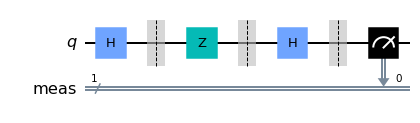

In [3]:
deutsch = QuantumCircuit(1)
deutsch.h(0)
deutsch.barrier()

deutsch.z(0)

#deutsch.i(0)

deutsch.barrier()
deutsch.h(0)
deutsch.measure_all()
deutsch.draw('mpl')

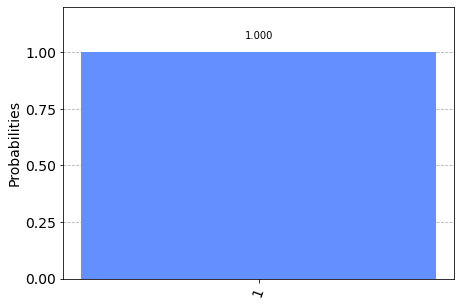

In [4]:
job = execute(deutsch, qmbackend, shots=1)
result = job.result()
plot_histogram(result.get_counts())

# Jozsa Algorithm: 

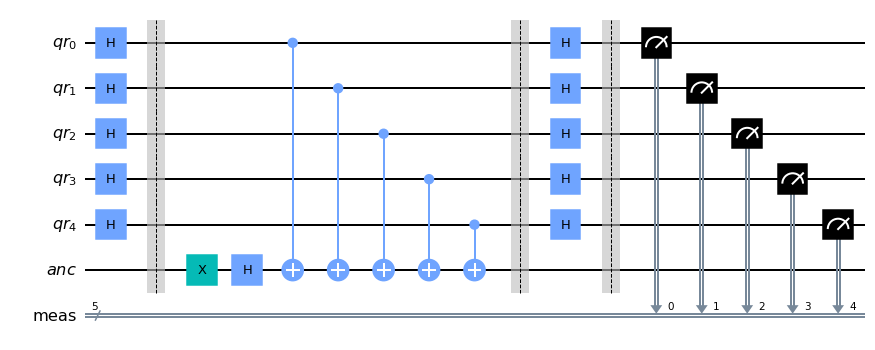

In [5]:
n = 5
qr = QuantumRegister(n, 'qr')
anc = QuantumRegister(1, 'anc')
meas = ClassicalRegister(n, 'meas')
jozsa = QuantumCircuit(qr, anc, meas)
jozsa.h(qr)
jozsa.barrier()

jozsa.x(anc)
jozsa.h(anc)
for control in qr:
    jozsa.cx(control,anc[0])
    
#jozsa.i([0,1,2])

jozsa.barrier()
jozsa.h(qr)
jozsa.barrier()
jozsa.measure(qr,meas)
jozsa.draw('mpl')

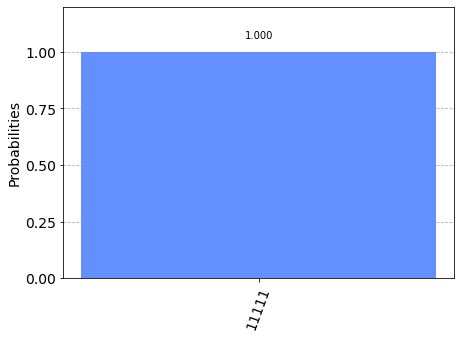

In [6]:
job = execute(jozsa, qmbackend, shots=1)
result = job.result()
plot_histogram(result.get_counts())

# BV Algorithm:

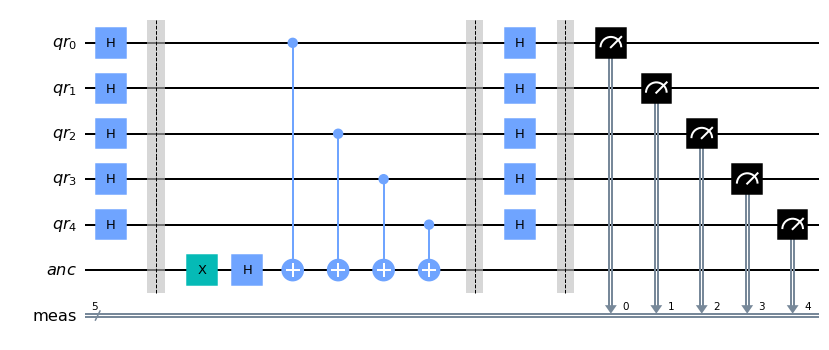

In [7]:
s = '11101'
n = 5
qr = QuantumRegister(n, 'qr')
anc = QuantumRegister(1, 'anc')
meas = ClassicalRegister(n, 'meas')
bv = QuantumCircuit(qr, anc, meas)
bv.h(qr)
bv.barrier()

bv.x(anc)
bv.h(anc)
s = s[::-1]
for qn in range(n):
    if s[qn] == '1':
        bv.cx(qr[qn],anc)

bv.barrier()
bv.h(qr)
bv.barrier()
bv.measure(qr,meas)
bv.draw('mpl')

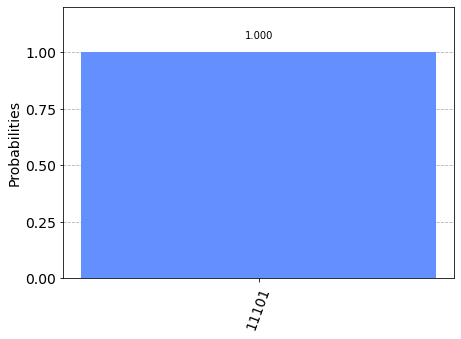

In [8]:
job = execute(bv, qmbackend, shots=1)
result = job.result()
plot_histogram(result.get_counts())

# Simon's Algorithm:

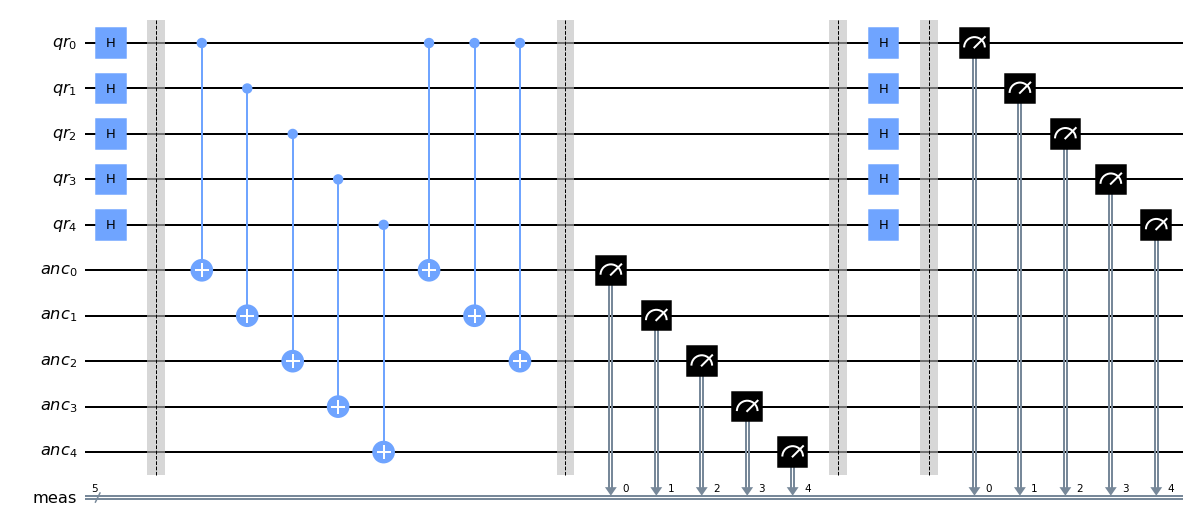

In [9]:
b = '00111'
n = 5
qr = QuantumRegister(n, 'qr')
anc = QuantumRegister(n, 'anc')
meas = ClassicalRegister(n, 'meas')
simon = QuantumCircuit(qr, anc, meas)
simon.h(qr)
simon.barrier()

##################################################################################################################

simon.cx(qr,anc)
b = b[::-1]
i = 0
while b[i] == '0':
    i += 1
for qn in range(n):
    if b[qn] == '1':
        simon.cx(qr[i],anc[qn])

##################################################################################################################        

simon.barrier()
simon.measure(anc,meas)
simon.barrier()

simon.h(qr)

simon.barrier()
simon.measure(qr,meas)
simon.draw('mpl')

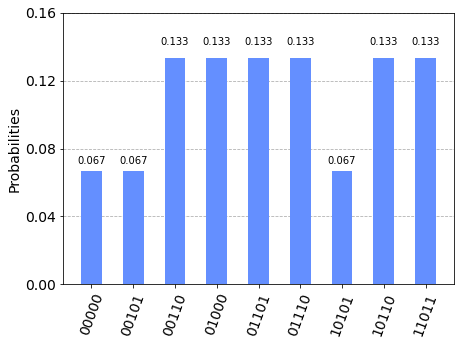

In [10]:
job = execute(simon, qmbackend, shots=n+10)
result = job.result()
result.get_counts()
plot_histogram(result.get_counts())

In [11]:
b = b[::-1]
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)
for z in result.get_counts():
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

00111.00101 = 0 (mod 2)
00111.00000 = 0 (mod 2)
00111.01110 = 0 (mod 2)
00111.10110 = 0 (mod 2)
00111.00110 = 0 (mod 2)
00111.01000 = 0 (mod 2)
00111.10101 = 0 (mod 2)
00111.11011 = 0 (mod 2)
00111.01101 = 0 (mod 2)


# Shor's Algorithm

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math
from fractions import Fraction
np.set_printoptions(precision=3, suppress=True)

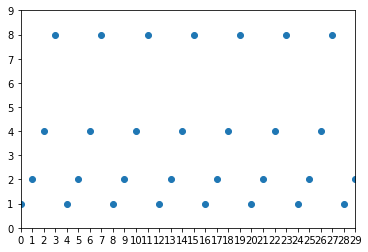

In [64]:
N = 15
a = 2
Q = 30
xlist = np.array(list(range(Q)))
ylist = np.array([(a**x)%N for x in xlist])
plt.scatter(xlist,ylist)
plt.xlim(0,max(xlist))
plt.ylim(0,max(ylist)+1)
plt.xticks(xlist)
plt.show()
for i in range(1,Q):
    if ylist[i] == 1:
        s = i
        break

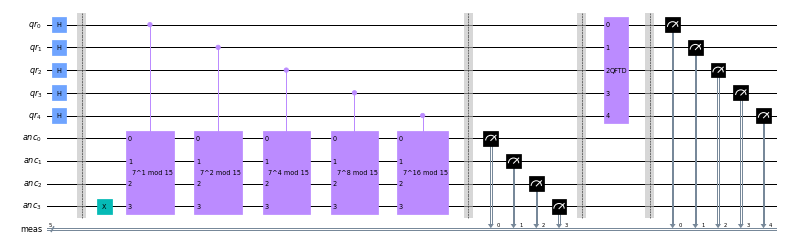

In [51]:
#Works for a^x mod 15

N = 15
#nqr = math.ceil(math.log(N*N,2))
nqr = math.ceil(math.log(2*N-1,2))
nanc = math.ceil(math.log(N,2))
a = 7
Q = 2**nqr

qr = QuantumRegister(nqr, 'qr')
anc = QuantumRegister(nanc, 'anc')
meas = ClassicalRegister(nqr, 'meas')
shor = QuantumCircuit(qr, anc, meas)
shor.h(qr)
shor.barrier()

##################################################################################################################

shor.x(anc[nanc-1])
def amod15(a, exp):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")    
    else:
        qc = QuantumCircuit(4)    
        for i in range(exp):
            if a in [2,13]:
                qc.swap(0,1)
                qc.swap(1,2)
                qc.swap(2,3)
            if a in [7,8]:
                qc.swap(2,3)
                qc.swap(1,2)
                qc.swap(0,1)
            if a in [4, 11]:
                qc.swap(1,3)
                qc.swap(0,2)
            if a in [7,11,13]:
                for q in range(4):
                    qc.x(q)
    return qc

def c_amod15(a, exp):
    qc = amod15(a,exp).to_gate()
    qc.name = "%i^%i mod 15" % (a, exp)
    c_qc = qc.control()
    return c_qc

if N == 15:
    for nq in range(nqr):
        shor.append(c_amod15(a, 2**nq), [qr[nq]]+[qanc for qanc in anc])
else:
    raise ValueError("Currently N is only 15")
    
##################################################################################################################

shor.barrier()
shor.measure(anc,meas[:nanc])
shor.barrier()

##################################################################################################################

def qdft(n):
    qc = QuantumCircuit(n)
    for q in range(n//2):
        qc.swap(q, n-q-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

def qdftd(n):
    qc = qdft(n).inverse().to_gate()
    qc.name = "QFTD" 
    return qc

shor.append(qdftd(nqr), qr)

##################################################################################################################

shor.barrier()
shor.measure(qr,meas)
shor.draw(output='mpl', fold=-1, scale=0.5)

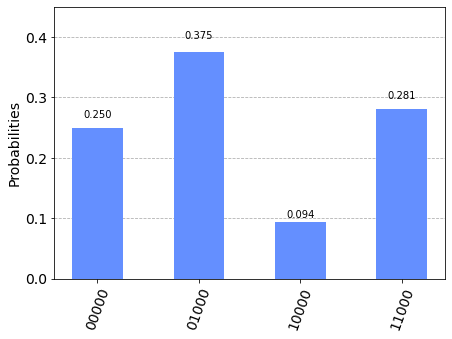

In [52]:
job = execute(shor, qmbackend, shots=Q)
result = job.result()
result.get_counts()
plot_histogram(result.get_counts())

In [65]:
print("Expected peak deltas [Cheating]:")
print([(Q/s)*i for i in range(s)])

print("\nObserved peak deltas:")
values = [int(output,2) for output in result.get_counts()]
print(values)

print("\nPunctued deltas:")
values = [int(output,2)/Q for output in result.get_counts()]
print(values)

print("\nDenominators")
values = [Fraction(int(output,2)/Q).limit_denominator(15).denominator for output in result.get_counts()]
print(values)

print("\nResult:")
if s == math.lcm(*values):
    print("Success")
    print(s)
else:
    print("Failure")
    print(math.lcm(*values))

Expected peak deltas [Cheating]:
[0.0, 7.5, 15.0, 22.5]

Observed peak deltas:
[8, 16, 0, 24]

Punctued deltas:
[0.26666666666666666, 0.5333333333333333, 0.0, 0.8]

Denominators
[15, 15, 1, 5]

Result:
Failure
15


# Grover's Algorithm

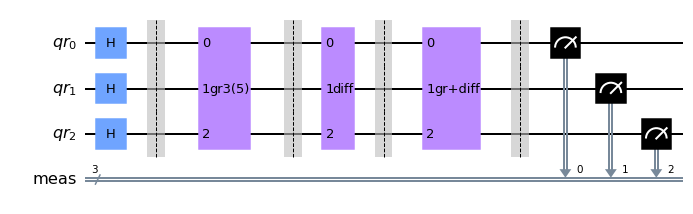

In [43]:
#Works for 2, 3 qubits databases

n = 3
marker = 5
Q = 2**n

qr = QuantumRegister(n, 'qr')
meas = ClassicalRegister(n, 'meas')
grover = QuantumCircuit(qr, meas)
grover.h(qr)
grover.barrier()
    
##################################################################################################################

def gr2(marker):
    if marker not in range(4):
        raise ValueError("marker must be in range")
    else:
        qc = QuantumCircuit(2)
        binval = format(marker,"02b")
        binval = binval[::-1]
        xlist = []
        for i in range(2):
            if binval[i] == '0':
                xlist.append(i)
        if xlist:
            qc.x(xlist)
        qc.cz(0,1)
        if xlist:
            qc.x(xlist)
        qc = qc.to_gate()
        qc.name = "gr2(%i)" % (marker)
    return qc

def gr3(marker):
    if marker not in range(8):
        raise ValueError("marker must be in range")
    else:
        qc = QuantumCircuit(3)
        binval = format(marker,"03b")
        binval = binval[::-1]
        xlist = []
        for i in range(3):
            if binval[i] == '0':
                xlist.append(i)
        if xlist:
            qc.x(xlist)
        qc.mcp(math.pi,[0,1],2)
        if xlist:
            qc.x(xlist)
        qc = qc.to_gate()
        qc.name = "gr3(%i)" % (marker)
    return qc

def gr3dual():
    qc = QuantumCircuit(3)
    qc.z(1)
    qc.cz([2,2,1],[1,0,0])
    qc = qc.to_gate()
    qc.name = "gr3dual(2,5)"
    return qc

if n == 2:
    grover.append(gr2(marker),qr)
elif n == 3:
    if marker == -1:
        grover.append(gr3dual(),qr)
    else:
        grover.append(gr3(marker),qr)
else:
    raise ValueError("Currently n is only 2 or 3")

##################################################################################################################

grover.barrier()

##################################################################################################################

def hdiff(n):
    qc = QuantumCircuit(n)
    qc.x(list(range(n)))
    qc.mcp(math.pi, list(range(n-1)), n-1)
    qc.x(list(range(n)))
    qc = qc.to_gate()
    qc.name = "hdiff"
    return qc

def diff(n):
    qc = QuantumCircuit(n)
    qc.h(list(range(n)))
    qc.append(hdiff(n),list(range(n)))
    qc.h(list(range(n)))
    qc = qc.to_gate()
    qc.name = "diff"
    return qc
    
grover.append(diff(n), qr)

##################################################################################################################

grover.barrier()

##################################################################################################################

def grdiff(n):
    qc = QuantumCircuit(n)
    if n == 2:
        qc.append(gr2(marker),list(range(n)))
    elif n == 3:
        if marker == -1:
            qc.append(gr3dual(),list(range(n)))
        else:
            qc.append(gr3(marker),list(range(n)))
    else:
        raise ValueError("Currently n is only 2 or 3")
    qc.append(diff(n),list(range(n)))
    qc = qc.to_gate()
    qc.name = "gr+diff"
    return qc

if marker == -1:
    k = 2
else:
    k = 1
t = math.ceil((math.pi/4)*math.sqrt(Q/k))
for c in range(t-2):
    grover.append(grdiff(n),qr)
    
##################################################################################################################

grover.barrier()
grover.measure(qr,meas)
grover.draw(output='mpl', fold=-1)

In [ ]:
job = execute(grover, qmbackend, shots=1)
result = job.result()
result.get_counts()
plot_histogram(result.get_counts())

In [ ]:
for output in result.get_counts():
    value = int(output,2)
if marker == value:
    print("Success")